# Visualizações Gráficas utilizando Amazon SQS e S3 usando Python

## Importar Libs

* json - Manipulação de Arquivos JSON.
* os - Manipulação de caminhos de arquivos.
* boto3 - Comunicação com os serviços da Amazon.
* datetime - Manipulação de data e hora
* pandas - Manipulação de DataFrames.
* numpy - Manipulações Numéricas.
* seaborn - Criação de gráficos simples.
* matplotlib.pyplot - Criação de gráficos simples.
* matplotlib.ticker - Formatação de número de etiqueta.
* configparser - Manipulação de arquivos de configuração.

In [170]:
import json
import os
import boto3
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from configparser import ConfigParser

## Carregar Arquivo de Configuração

In [146]:
#Carregar o arquivo de configuração
parser = ConfigParser()
parser.read('aws.ini')

#Definição das variáveis dentro do arquivo
aws_secret_key_id=parser.get('aws_credentials', 'aws_secret_key_id')
aws_secret_access_key=parser.get('aws_credentials', 'aws_secret_access_key')
url=parser.get('SQS', 'url')
bucket=parser.get('S3', 'bucket')

## Carregar base de dados

Os dados representam o Volume de tráfego interestadual do Metro. Entre os dados, estão informações meteorológicos por hora e sobre feriados.

Link para download do conjunto: [conjunto de dados do volume de tráfego interestadual da Metro](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

In [147]:
arquivo_csv = os.path.join(os.path.abspath(os.curdir), 'Metro_Interstate_Traffic_Volume.csv')
df_csv = pd.read_csv(arquivo_csv)

df_csv.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Definir Função de Envio para SQS 

In [31]:
def EnviarMensagensParaSQS(df):
    sqs_client=boto3.client('sqs')
    for ind, row in df.iterrows():
        response = sqs_client.send_message(
            QueueUrl=url,
            DelaySeconds=3,
            MessageBody=(row.to_json()))

In [30]:
EnviarMensagensParaSQS(df_csv)

## Definir Função para Recuperar Mensagens do SQS

In [36]:
def RecuperarMensagensDaFila(url):
    sqs_client=boto3.client('sqs')
    mensagens=[]
    
    while True:
        response=sqs_client.receive_message(
            QueueUrl=url,
            AttributeNames=['All'],
            MaxNumberOfMessages=10
        )
        try:
            corpo_mensagem=list(map(lambda x: json.loads(x['Body']), response['Messages']))
            mensagens.extend(corpo_mensagem)            
        except KeyError:
            break
        
        entradas=[{'Id':msg['MessageId'],
                  'ReceiptHandle':msg['ReceiptHandle']} for msg in response['Messages']]
        response=sqs_client.delete_message_batch(QueueUrl=url,
                                                 Entries=entradas)
        
    
    return mensagens

In [39]:
mensagens_sqs=RecuperarMensagensDaFila(url)

In [40]:
mensagens_sqs

[{'holiday': 'None',
  'temp': 289.58,
  'rain_1h': 0.0,
  'snow_1h': 0.0,
  'clouds_all': 90,
  'weather_main': 'Clouds',
  'weather_description': 'overcast clouds',
  'date_time': '2012-10-02 11:00:00',
  'traffic_volume': 4767},
 {'holiday': 'None',
  'temp': 291.14,
  'rain_1h': 0.0,
  'snow_1h': 0.0,
  'clouds_all': 75,
  'weather_main': 'Clouds',
  'weather_description': 'broken clouds',
  'date_time': '2012-10-02 13:00:00',
  'traffic_volume': 4918},
 {'holiday': 'None',
  'temp': 288.28,
  'rain_1h': 0.0,
  'snow_1h': 0.0,
  'clouds_all': 40,
  'weather_main': 'Clouds',
  'weather_description': 'scattered clouds',
  'date_time': '2012-10-02 09:00:00',
  'traffic_volume': 5545},
 {'holiday': 'None',
  'temp': 289.36,
  'rain_1h': 0.0,
  'snow_1h': 0.0,
  'clouds_all': 75,
  'weather_main': 'Clouds',
  'weather_description': 'broken clouds',
  'date_time': '2012-10-02 10:00:00',
  'traffic_volume': 4516},
 {'holiday': 'None',
  'temp': 290.13,
  'rain_1h': 0.0,
  'snow_1h': 0.0,


## Exportar Mensagens para o Formato JSON

In [44]:
with open('arquivo.json', 'w') as f:
    f.write(json.dumps(mensagens_sqs, ensure_ascii=False))

## Definir Função para Realizar Upload no Bucket

In [45]:
def RealizarUploadBucket(nome_arquivo,bucket,nome_objeto):
    s3_client=boto3.client('s3')
    response=s3_client.upload_file(nome_arquivo,bucket,nome_objeto)

In [48]:
RealizarUploadBucket('arquivo.json',bucket,'metro.json')

## Definir Função para Recuperar Arquivo JSON

In [140]:
def RecuperarArquivoJson(caminho):
    s3_client = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=aws_secret_key_id,
    aws_secret_access_key=aws_secret_access_key
)
    obj = s3_client.Bucket(bucket).Object(caminho).get()
    return pd.read_json(obj['Body'])

In [123]:
metro=RecuperarArquivoJson('metro.json')
metro.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,289.58,0,0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
1,None,291.14,0,0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
2,None,288.28,0,0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
3,None,289.36,0,0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
4,None,290.13,0,0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026


## Visualizações de Dados

In [141]:
metro=df_csv

In [205]:
def ConverterParaData(elemento):    
	return datetime.datetime.strptime(elemento, '%Y-%m-%d %H:%M:%S')

In [172]:
metro['date_time'] = metro['date_time'].apply(ConverterParaData)

Em primeiro lugar, vamos analisar os padrões gerais e dependências dos valores de tráfego e temperatura por dados de tempo.

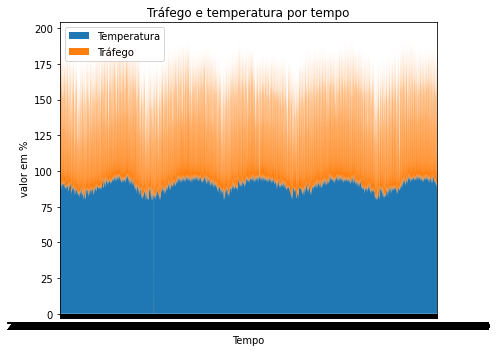

In [145]:
temperatura = metro['temp'].values
trafego = metro['traffic_volume'].values
tempo = metro['date_time'].values

temperatura_trafego = np.array([(temperatura/temperatura.max())* 100,
                   	(trafego/trafego.max())* 100])

fig, ax = plt.subplots(figsize=(7, 5))
ax.stackplot(tempo,
             temperatura_trafego,
             labels=['Temperatura', 'Tráfego'])
ax.set_title('Tráfego e temperatura por tempo')
ax.legend(loc='upper left')
ax.set_ylabel('valor em %')
ax.set_xlabel('Tempo')
ax.set_xlim(xmin=tempo[0], xmax=tempo[-1])
fig.tight_layout()

Como podemos ver, essas dependências gráficas têm aproximadamente a mesma forma, então vamos nos certificar disso, comparando-as com um gráfico de dispersão e dados de tráfego categóricos.

In [148]:
def CategoriaTrafego(value):
	return 'High' if value > 4000 else 'Low' \
                  if value < 1000 else 'Average'            

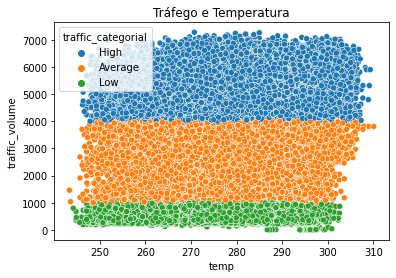

In [149]:
metro['traffic_categorial'] = metro['traffic_volume'].apply(CategoriaTrafego)
# plot
sns.scatterplot(y='traffic_volume',
                x='temp',
                hue='traffic_categorial',
                data = metro.loc[metro.temp > 50])
plt.title('Tráfego e Temperatura')
plt.show()

Como esperado, esses valores têm aproximadamente a mesma forma.

A seguir, realizaremos características estatísticas de dados meteorológicos e valores de tráfego com o histograma e gráfico de densidade.

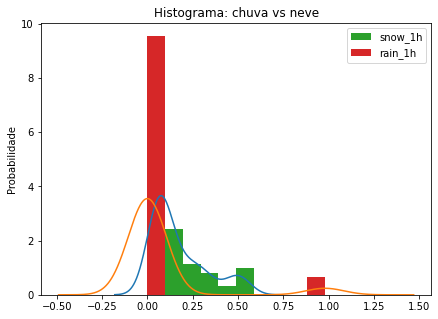

In [156]:
fig, ax = plt.subplots(figsize=(7, 5))
clima = metro[['snow_1h','rain_1h']].loc[metro['snow_1h'] > 0.001]

clima.plot.kde(ax=ax, legend=False)
clima.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probabilidade')
ax.set_title('Histograma: chuva vs neve')
plt.show()

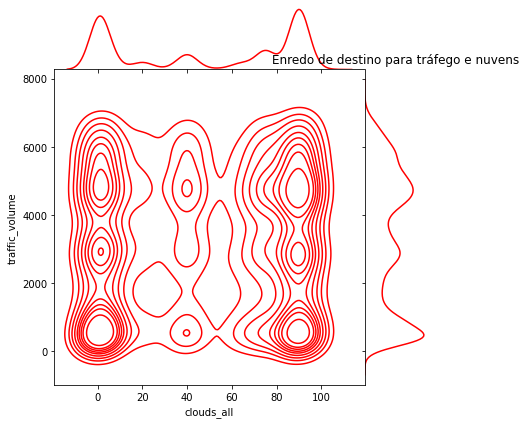

In [151]:
sns.jointplot(x="clouds_all",
              y="traffic_volume",
              data=metro,
              kind="kde",
    	     space=0,
              color="r")
plt.title('Enredo de destino para tráfego e nuvens')
plt.show()

Depois de analisar os gráficos, podemos assumir que os dados de chuva e neve têm uma distribuição exponencial devido à sua sazonalidade. Também vemos que as nuvens têm impacto no tráfego.

O conjunto de dados contém dados categóricos sobre feriados e clima. Portanto, contaremos sua quantidade e construiremos diagramas de pizza.

In [259]:
def GraficoPizza(coluna,titulo):
    fig, ax = plt.subplots(figsize=(7, 5))
    valores_unicos = metro[metro['holiday'] != 'None'][coluna].value_counts()
    valores_unicos_limitados = valores_unicos
    ax.pie(valores_unicos_limitados,
   		   labels=valores_unicos_limitados.index,
       	   autopct='%1.1f%%',
   	       startangle=90)
    
    circulo_central = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(circulo_central)
    ax.axis('equal')
    plt.tight_layout()
    plt.title(titulo, weight='bold', fontsize=16)
    plt.show()

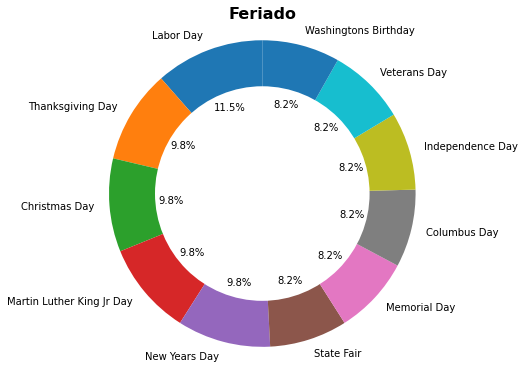

In [260]:
GraficoPizza('holiday','Feriado')

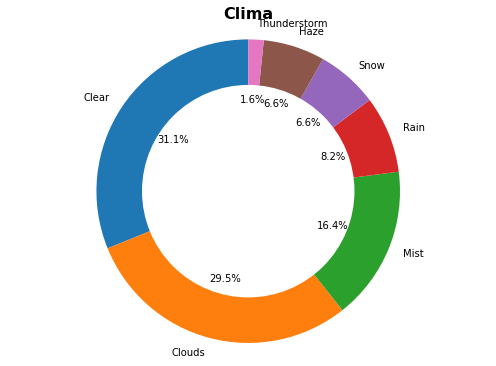

In [261]:
GraficoPizza('weather_main','Clima')

O código do segundo diagrama não é inferência, pois é idêntico ao anterior.
A seguir, analisaremos a intensidade do tráfego em feriados com o countplot.

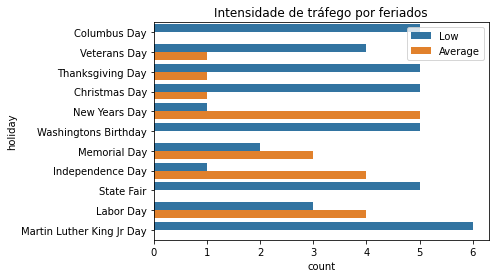

In [160]:
sns.countplot(y='holiday',
              hue='traffic_categorial',
              data=metro[metro['holiday'] != 'None'])
plt.legend(loc='upper right')
plt.title('Intensidade de tráfego por feriados')
plt.show()

Analisando o gráfico recebido, vemos que não há tráfego de alta intensidade nos feriados.

A seguir, usaremos pyplot e seaborn para construir e analisar o efeito da intensidade do tráfego nos dados de tempo e tempo.

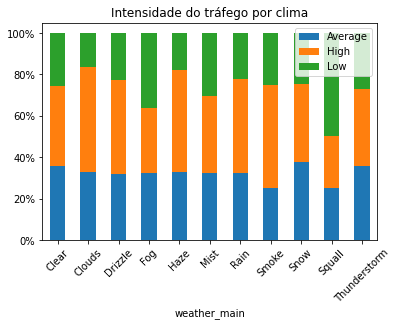

In [164]:
metro.groupby(['weather_main','traffic_categorial']).size() \
       	.groupby(level=0).apply(lambda x: 100 * x / x.sum()) \
       	.unstack().plot(kind='bar', stacked=True)

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Intensidade do tráfego por clima')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

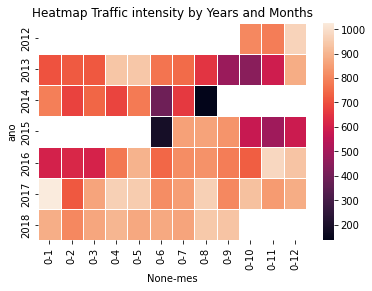

In [173]:
df=metro.copy()

df['date_time']=df['date_time']

df['ano']=df['date_time'].dt.year
df['mes']=df['date_time'].dt.month

metro_heatmaps = df.groupby(['mes', 'ano']) \
	          .size().reset_index() \
              .pivot(columns='mes', index='ano')

sns.heatmap(metro_heatmaps, annot=False, linewidths=.5)
plt.title('Heatmap Traffic intensity by Years and Months')
plt.show()

O primeiro diagrama mostra que, para nossos dados, não há alta correlação entre a intensidade do tráfego e os dados meteorológicos. A intensidade do tráfego do mapa de calor demonstra que a intensidade do tráfego em 2017-2018 foi maior.

A seguir, usaremos as ferramentas de análise estatística marítima para analisar a distribuição da intensidade do tráfego por dados de tempo: horas, dias e meses. Para este propósito, com a biblioteca de data-hora, iremos extrair da coluna data_time : hora, dias da semana, meses, anos, em colunas separadas do dataframe Pandas.

In [209]:
def TempoCategoria(value):
	return 'Evening' if value > datetime.time(18, 0) else 'Day' \
                    if value < datetime.time(11, 0) else 'Evening'

In [ ]:
df['date_time_year'] = df['date_time'].apply(lambda x: x.year)
df['date_time_time'] = df['date_time'].apply(lambda x: x.time())
df['date_time_month'] = df['date_time'].apply(lambda x: x.month_name())
df['date_time_day'] = df['date_time'].apply(lambda x: x.day_name())
df['date_time_category'] = df['date_time_time'].apply(TempoCategoria)

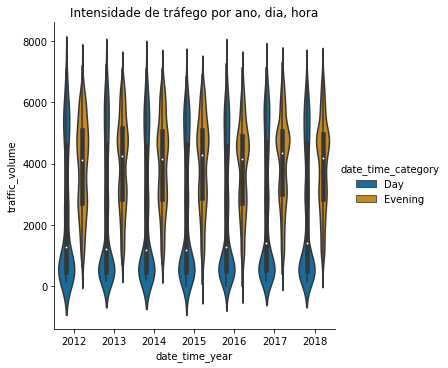

In [223]:
sns.catplot(x="date_time_year", y="traffic_volume", hue="date_time_category",
data=df, palette="colorblind", kind='violin', legend=True)
plt.title('Intensidade de tráfego por ano, dia, hora')
plt.show()

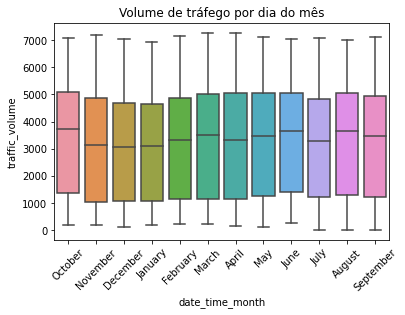

In [224]:
sns.boxplot(x='date_time_month', y='traffic_volume', data = df)
plt.xticks(rotation=45)
plt.title('Volume de tráfego por dia do mês')
plt.show()

Depois de analisar os dados com a trama do violino, podemos concluir que o tráfego tem mais intensidade à noite e esse padrão se mantém por todos os anos. Ao mesmo tempo, o valor médio do tráfego para cada um dos meses é aproximadamente o mesmo.

A seguir, exploramos o impacto dos dias da semana no volume de tráfego. Usaremos as ferramentas catplot e boxplot para essa finalidade.

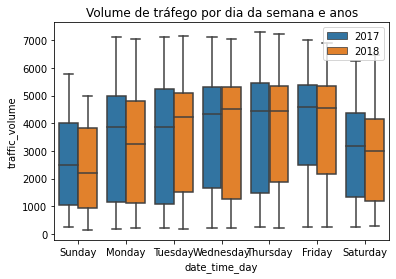

In [229]:
dff_years = df[(df.date_time_year == 2017)|(df.date_time_year == 2018)]
sns.boxplot(x="date_time_day",
            y="traffic_volume",
   	     	hue="date_time_year",
        	data=dff_years)
plt.legend(loc='upper right')
plt.title('Volume de tráfego por dia da semana e anos')
plt.show()

Esse diagrama mostra que o volume e a intensidade do tráfego diminuem nos finais de semana. Este padrão permanece o mesmo para o período diurno e noturno e, em geral, para 2017-2018 anos.